In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io

import os, re

import claude.utils as cu
import claude.claudeflow.autoencoder as ae
import claude.claudeflow.helper as cfh
import claude.claudeflow.training as cft

In [2]:
from random import randrange
seed = randrange(1e5)
tf.set_random_seed(seed)
np.random.seed(seed)

summaries_dir = 'MINE'
os.makedirs(summaries_dir, exist_ok=True)

# Parameters
# Channel Parameters
chParam = cu.AttrDict()
chParam.M = 16
if chParam.M == 16:
    chParam.SNR_db = 10
elif chParam.M == 64:
    chParam.SNR_db = 18
else:
    chParam.SNR_db = 22

# Auto-Encoder Parameters
aeParam = cu.AttrDict()
aeParam.constellationDim = 2
aeParam.constellationOrder = chParam.M
aeParam.nLayers     = 2
aeParam.nHidden     = 32
aeParam.nLayersMINE = 2
aeParam.nHiddenMINE = 20
aeParam.activation  = tf.nn.relu
aeParam.dtype       = tf.float32
aeParam.cpx_dtype   = tf.complex64

# Training Parameters
trainingParam = cu.AttrDict()
trainingParam.MINE_learningRate = 0.0005
trainingParam.MINE_iterations   = 1000
trainingParam.MINE_batchSize    = 200

trainingParam.encoder_iterations   = [1000, 10000, 10000]
trainingParam.encoder_batchSize    = [100, 100, 1000]
trainingParam.encoder_learningRate = [0.01, 0.01, 0.001]

trainingParam.decoder_iterations   = 1000
trainingParam.decoder_batchSize    = 16 * chParam.M
trainingParam.decoder_learningRate = 0.001

# TF constants
one = tf.constant(1, aeParam.dtype)
two = tf.constant(2,aeParam.dtype)
PI = tf.constant(np.pi,aeParam.dtype)

twoZeroCpx = tf.constant(2, aeParam.cpx_dtype)

In [3]:
# channel implemented with pass through gradient, see discussion here:
# https://github.com/Fritschek/Wireless_encoding_with_MI_estimation/issues/1
@tf.custom_gradient
def channel(x):
    SNR_db = tf.constant(chParam.SNR_db, dtype=aeParam.dtype)
    sigma2 = one / cfh.dB2lin(SNR_db, 'dB')
    noise_cpx = tf.complex(tf.random_normal(shape=tf.shape(x), dtype=aeParam.dtype),
                           tf.random_normal(shape=tf.shape(x), dtype=aeParam.dtype))
    noise = tf.cast(tf.sqrt(sigma2), aeParam.cpx_dtype)\
            * tf.rsqrt(twoZeroCpx) * noise_cpx
    y = x + noise
    def grad(dy):
        return dy
    return y, grad

In [4]:
def tx(X):
    # Tx Graph
    x_vec, x_seed = ae.encoder(X, aeParam, name='encoder')
    x = cfh.real2complex(x_vec)

    # Channel Graph
    y = channel(x)

    y_vec = cfh.complex2real(y)
    
    return x_vec, y_vec, x, y, x_seed

def MINE(x_vec_joint, y_vec_joint, y_vec_marginal):
    inp_joint = tf.concat((x_vec_joint, y_vec_joint), axis=-1)
    inp_marginal = tf.concat((x_vec_joint, y_vec_marginal), axis=-1)
    out_joint = ae._encoder(inp_joint,
                            aeParam.nHiddenMINE,
                            aeParam.nLayersMINE,
                            aeParam.activation,
                            kernel_initializer=tf.random_normal_initializer(stddev=0.05),
                            nOutput=1,
                            name='MINE')
    out_marginal = ae._encoder(inp_marginal,
                               aeParam.nHiddenMINE,
                               aeParam.nLayersMINE,
                               aeParam.activation,
                               kernel_initializer=tf.random_normal_initializer(stddev=0.05),
                               nOutput=1,
                               name='MINE')

    MI_est = tf.reduce_mean(out_joint) - tf.log(tf.reduce_mean(tf.exp(out_marginal)))
    
    return MI_est

In [5]:
X_joint = tf.placeholder(aeParam.dtype, shape=(None, chParam.M))
X_marginal = tf.placeholder(aeParam.dtype, shape=(None, chParam.M))

x_vec_joint, y_vec_joint, x_joint, y_joint, x_seed = tx(X_joint)
_, y_vec_marginal, _, _, _ = tx(X_marginal)

constellation = cfh.real2complex(x_seed)
MI_est = MINE(x_vec_joint, y_vec_joint, y_vec_marginal)

decoder = ae.decoder(y_vec_joint, aeParam, fromComplex=False)
loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=X_joint, logits=decoder)

gaussian_MI = cfh.gaussianMI(x_joint, y_joint, cfh.real2complex(x_seed), chParam.M, dtype=aeParam.dtype)
Px = tf.constant( 1/chParam.M, aeParam.dtype )
softmax_MI = cfh.softmaxMI(tf.nn.softmax(decoder), X_joint, Px)

metricsDict = {'softmax_MI_metric':softmax_MI, 'gaussian_MI_metric':gaussian_MI}
meanMetricOpsDict, updateOps, resetOps = cft.create_mean_metrics(metricsDict)

W0324 20:21:20.661957 140708513933120 deprecation.py:506] From /home/rasmus/.conda/envs/claudeOnline/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0324 20:21:22.868181 140708513933120 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [6]:
summary_MINE = tf.summary.scalar('MINE_MI', MI_est)
summary_encoder = tf.summary.scalar('encoder_MI', MI_est)

In [7]:
MINE_vars = [var for var in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES) if 'MINE' in var.name]
MINE_optimizer = tf.train.AdamOptimizer(learning_rate=trainingParam.MINE_learningRate)
MINE_optimizer = MINE_optimizer.minimize(-MI_est, var_list=MINE_vars)

encoder_learning_rate = tf.placeholder(tf.float32, shape=())
encoder_vars = [var for var in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES) if 'encoder' in var.name]
encoder_optimizer = tf.train.AdamOptimizer(learning_rate=encoder_learning_rate)
encoder_optimizer = encoder_optimizer.minimize(-MI_est, var_list=encoder_vars)

decoder_vars = [var for var in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES) if 'decoder' in var.name]
decoder_optimizer = tf.train.AdamOptimizer(learning_rate=trainingParam.decoder_learningRate)
decoder_optimizer = decoder_optimizer.minimize(loss, var_list=decoder_vars)

W0324 20:21:23.438755 140708513933120 deprecation.py:323] From /home/rasmus/.conda/envs/claudeOnline/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [8]:
# TRAINING
init = tf.global_variables_initializer()
sess = tf.Session()

writer = tf.summary.FileWriter(summaries_dir + '/MINE', sess.graph)

sess.run(init)

In [9]:
encoder_c = 1
MINE_c = 1

In [10]:
def sample(batchSize):
    data_joint, _, _ = cu.hotOnes(batchSize,(1,0),chParam.M)
    data_marginal, _, _ = cu.hotOnes(batchSize,(1,0),chParam.M)
    return data_joint, data_marginal

def MINE_train():
    global MINE_c
    for ii in range(1, trainingParam.MINE_iterations+1):
        data_joint, data_marginal = sample(trainingParam.MINE_batchSize)
        feedDict = {X_joint: data_joint, X_marginal: data_marginal}
        [_, out_summary_MINE] = sess.run([MINE_optimizer, summary_MINE], feed_dict=feedDict)
        writer.add_summary(out_summary_MINE, MINE_c)
        MINE_c += 1

def encoder_train(iterations, batchSize, learning_rate):
    global encoder_c
    trainMINEnow = iterations//10
    for ii in range(1, iterations+1):
        data_joint, data_marginal = sample(batchSize)
        feedDict = {X_joint: data_joint, X_marginal: data_marginal, encoder_learning_rate: learning_rate}
        [_, out_summary_encoder] = sess.run([encoder_optimizer, summary_encoder], feed_dict=feedDict)
        writer.add_summary(out_summary_encoder, encoder_c)
        encoder_c += 1

        if ii % trainMINEnow == 0:
            MINE_train()
            
def decoder_train(iterations, batchSize, learning_rate):
    for ii in range(1, iterations+1):
        data_joint, data_marginal = sample(batchSize)
        feedDict = {X_joint: data_joint, X_marginal: data_marginal}
        sess.run(decoder_optimizer, feed_dict=feedDict)
    
    sess.run(resetOps)
    for ii in range(1, iterations+1):
        data_joint, data_marginal = sample(batchSize)
        feedDict = {X_joint: data_joint, X_marginal: data_marginal}
        sess.run(updateOps, feed_dict=feedDict)
    out_meanMetrics = sess.run(list(meanMetricOpsDict.values()), feed_dict=feedDict)
        
    return {'softmaxMI': out_meanMetrics[0], 'gaussianMI': out_meanMetrics[1]}

In [11]:
# init training
MINE_train()

# encoder/MINE training
encoder_train_list = zip(trainingParam.encoder_iterations,
                         trainingParam.encoder_batchSize,
                         trainingParam.encoder_learningRate)

MINE_count = 1
encoder_count = 1
for idx,(it,bs,lr) in enumerate(encoder_train_list):
    print('LOOP_TRAIN {}/{}'.format(idx+1, len(trainingParam.encoder_iterations)))
    encoder_train(it, bs, lr)

LOOP_TRAIN 1/3
LOOP_TRAIN 2/3
LOOP_TRAIN 3/3


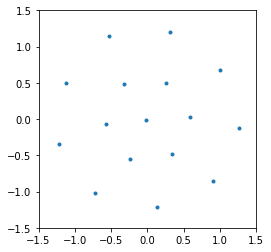

In [12]:
np_constellation = sess.run(constellation)
lim_ = 1.5
plt.plot(np.real(np_constellation), np.imag(np_constellation), '.');
plt.axis('square');
plt.xlim(-lim_,lim_);
plt.ylim(-lim_,lim_);

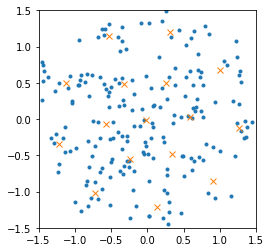

In [13]:
data_joint, data_marginal = sample(trainingParam.MINE_batchSize)
feedDict = {X_joint: data_joint, X_marginal: data_marginal}
np_y_joint = sess.run(y_joint, feed_dict=feedDict)
lim_ = 1.5
plt.plot(np.real(np_y_joint), np.imag(np_y_joint), '.');
plt.plot(np.real(np_constellation), np.imag(np_constellation), 'x');
plt.axis('square');
plt.xlim(-lim_,lim_);
plt.ylim(-lim_,lim_);

In [14]:
finalMI_ish = decoder_train(trainingParam.decoder_iterations, trainingParam.decoder_batchSize, trainingParam.decoder_learningRate)
print(finalMI_ish)

{'softmaxMI': 3.2269764, 'gaussianMI': 3.2069335}


In [15]:
SNR_db = np.arange(0, 30, 0.1)
C = np.log2(1 + cu.dB2lin(SNR_db, dBtype='dB'))

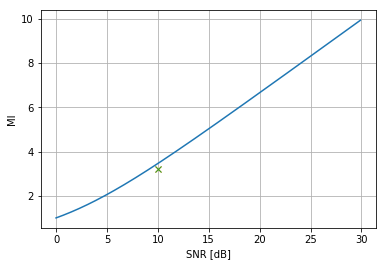

In [16]:
plt.plot(SNR_db, C)
plt.plot(chParam.SNR_db, finalMI_ish['gaussianMI'], 'x')
plt.plot(chParam.SNR_db, finalMI_ish['softmaxMI'], 'x')
plt.xlabel('SNR [dB]')
plt.ylabel('MI')
plt.grid(True)